# Machine Learning for Direct Marketing

The goal of this project is to predict term deposit subscribtions for a banking institution. The dataset comes from the UC Irvine Machine Learning Repository. I use the Logistic Regression classification algorithm for this project to predict the probability of a categorical variable - 1 (the client subscribes) or 0 (the client doesn't subscribe).

Assumptions of the linear regression:
1) The independent variables are independent of each other. That is, the model should have little or no multicollinearity.
2) The independent variables are linearly related to the log odds.
3) The records of this dataset present a large sample size for the logistic regression.

# EDA

In [133]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns

Load the dataset:

In [37]:
data = pd.read_csv('direct_marketing.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


The dataset includes 41,188 customer contact records and 21 fields, ranging from customer's education ('education') to customer's residential status ('housing'). The last field is our target variable 'y' we're trying to predict. 'Y' is a binary variable, where 0 values reflect customer who didn't subscribe, and 1 values reflect customers who did subscribe.

In [38]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [39]:
data = data.rename(columns={'y':'target'})

In [40]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

The education variable has categorical values that could be combined into other values to enhance categorization. Let's consider customers with 9 years of school education as customers with high-school education, and those with 6 or 4 years of school education as customers with basic education.

In [41]:
data['education']=np.where(data['education'] =='basic.9y', 'high.school', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'basic', data['education'])

Let's double check and see if the 'merger' was successful.

In [42]:
data['education'].unique()

array(['basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

Let's now figure out the total number of customers who subscribed to the term deposit, and the number of those who didn't.

In [43]:
data['target'].value_counts()

0    36548
1     4640
Name: target, dtype: int64

4640 of 41,188 customer records reflect subscription to the deposit.

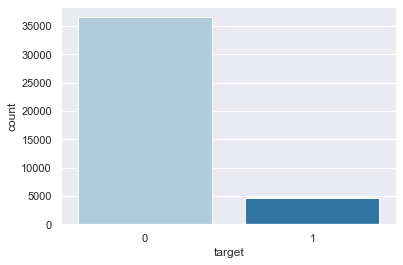

<Figure size 432x288 with 0 Axes>

In [44]:
sns.countplot(x='target',data=data, palette='Paired')
plt.show()
plt.savefig('target_plot')

Checking the missing values:

In [45]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
target            0
dtype: int64

Let's explore average field values for customers within each category of the target variable. Some of the insights:
Average ages for customers who subscribed to the term deposit and who didn't don't have a significant difference in their age. Most common values for default, housing, loan, and previous outcomes for both target groups are identical.

In [51]:
data.groupby(['target']).agg(lambda x:x.value_counts().index[0])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
target,,,,,,,,,,,,,,,,,,,,
0,31,admin.,married,high.school,no,yes,no,cellular,may,mon,85,1,999,0,nonexistent,1.4,93.994,-36.4,4.857,5228.1
1,31,admin.,married,university.degree,no,yes,no,cellular,may,thu,301,1,999,0,nonexistent,-1.8,92.893,-46.2,4.962,5099.1


In [52]:
data.groupby('target').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
target,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


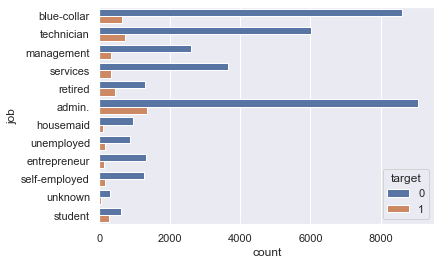

In [54]:
sns.set_theme(style='darkgrid')
sns.countplot(y="job", hue='target', data=data)
plt.show()

Job may be a significant predictor for our target variable. Administrative, blue-collar, technician workers, and retired customers subscribed to the deposit the most in absolute terms.

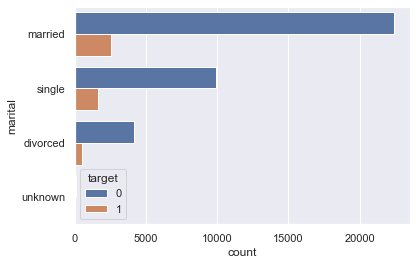

In [55]:
sns.countplot(y='marital', hue='target', data=data)
plt.show()

Customers in administrative positions mostly have university degrees. Many service workers hold high school education. Many technicians hold professional course certifications. 

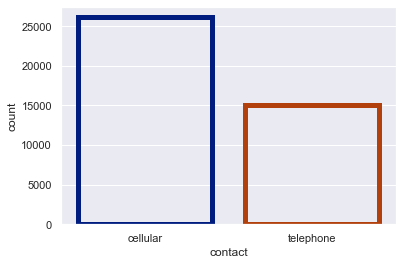

In [22]:
sns.countplot(x="contact", data=data,
              facecolor=(0, 0, 0, 0),
              linewidth=5,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

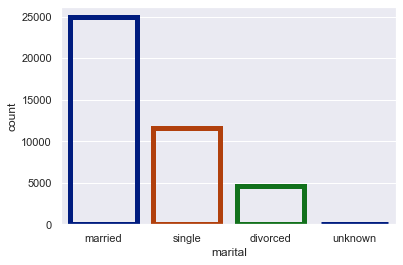

In [23]:
sns.countplot(x="marital", data=data,
              facecolor=(0, 0, 0, 0),
              linewidth=5,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

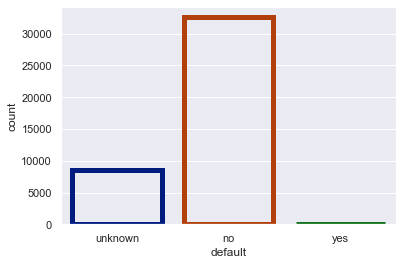

In [24]:
sns.countplot(x="default", data=data,
              facecolor=(0, 0, 0, 0),
              linewidth=5,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

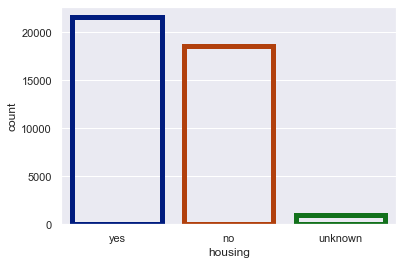

In [25]:
sns.countplot(x="housing", data=data,
              facecolor=(0, 0, 0, 0),
              linewidth=5,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

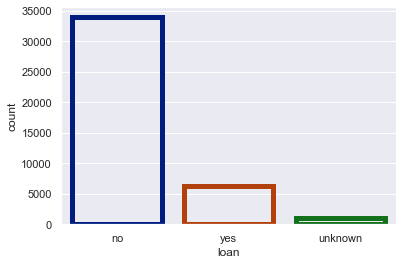

In [26]:
sns.countplot(x="loan", data=data,
              facecolor=(0, 0, 0, 0),
              linewidth=5,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

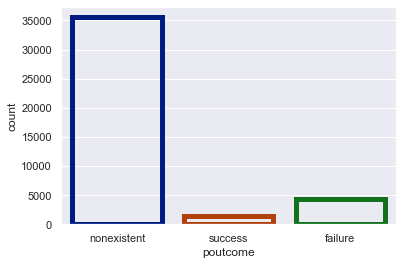

In [28]:
sns.countplot(x="poutcome", data=data,
              facecolor=(0, 0, 0, 0),
              linewidth=5,
              edgecolor=sns.color_palette("dark", 3))
plt.show()

We will base our prediction on customner's job, marital status, credit in default, housing/personal loan, and the outcome of previous campaigns. We will drop the variables we don't need.

In [100]:
data.drop(columns=['age', 'education', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'], axis=1, inplace=True)

In [101]:
data.head()

,job,marital,default,housing,loan,poutcome,target
0,blue-collar,married,unknown,yes,no,nonexistent,0
1,technician,married,no,no,no,nonexistent,0
2,management,single,no,yes,no,success,1
3,services,married,no,no,no,nonexistent,0
4,retired,married,no,yes,no,success,1


# Data Preprocessing

To indicate the absence or presence of some categorical effect that could shift the outcome, we can create dummy variables. They allow us to easily calculate ratios, and increase the significance of coefficients.

In [102]:
dummy_data = pd.get_dummies(data, columns =['job', 'marital', 'default', 'housing', 'loan', 'poutcome'])
dummy_data.drop(dummy_data.columns[[12, 16, 18, 21, 24]], axis=1, inplace=True)
dummy_data.columns

Index(['target', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single', 'default_no',
       'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

Plot the independence between independent variables:

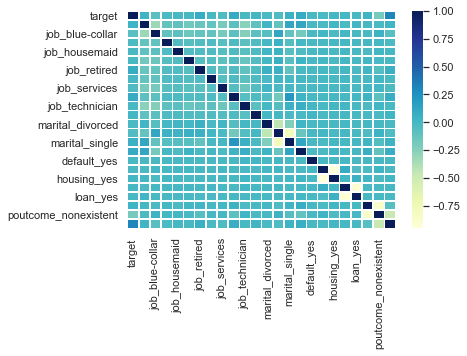

In [123]:
sns.heatmap(dummy_data.corr(), linewidth=-0.5, cmap="YlGnBu")
plt.show()

This computes pairwise correlation of columns. So far, no major visual issues arose. Splitting the data into a training (X) and a test (Y) set:

In [107]:
X = dummy_data.iloc[:,1:]
y = dummy_data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(30891, 23)

# The Classifier

We can now fit the logistic regression into the training set

In [108]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

We can now run the classifier prediction and then figure out the proportion of correct and incorrect predictions

In [110]:
y_pred = classifier.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[9046  110]
 [ 912  229]]


In [118]:
score_in_percent = "{:.2f}".format(classifier.score(X_test, y_test)*100)
print("Accuracy of the classifier on the test set is : " + str(score_in_percent) + "%")

Accuracy of the classifier on the test set is : 90.07%


In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9156
           1       0.68      0.20      0.31      1141

    accuracy                           0.90     10297
   macro avg       0.79      0.59      0.63     10297
weighted avg       0.88      0.90      0.88     10297



The four ratios/scores outlined in the classification report are key metrics for our classification.

Precision reflects what percentage of our predictions were correct. Recall is what percent of the positive cases we caught. F1 score reflects what percent of positive predictions were correct. Finally, support is the number of actual occurences of the class in y_test.

Some insights: Accuracy of positive predictions is, on average, 88%. The classifer has caught 90% of the total positive predictions.


# Classifier Visualization with Principal Component Analysis

The classifier visualization helps determine the decision boundaries. Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

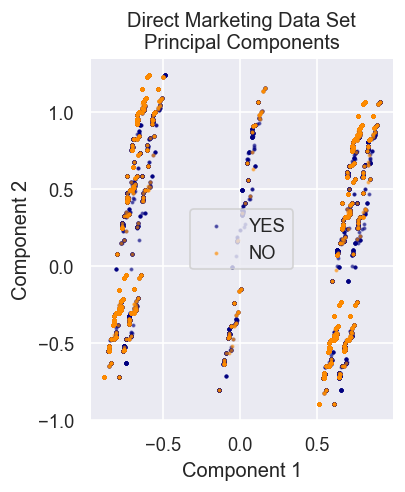

In [128]:
X = dummy_data.iloc[:,1:]
y = dummy_data.iloc[:,0]
pca = PCA(n_components=2).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(pca, y, random_state=0)
plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='YES', s=2, color='navy')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='NO', s=2, color='darkorange')
plt.legend()
plt.title('Direct Marketing Data Set\nPrincipal Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.gca().set_aspect('equal')
plt.show()

The Logistic Regression model's accuracy has been reduced due to PCA, but it is because PCA reduces the amount of dimension, so some information has been removed from our data.